In [1]:
import sys
sys.path.append("../") # This version of the notebook is in the subfolder "notebooks" of the repo

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy

from mbt_gym.gym.TradingEnvironment import TradingEnvironment, ASSET_PRICE_INDEX, INVENTORY_INDEX
from mbt_gym.gym.Traders import AmmTrader, MarketOrderTrader

from mbt_gym.agents.BaselineAgents import *
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.helpers.plotting import *
from mbt_gym.agents.BaselineAgents import CarteaJaimungalMmAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import CjCriterion, CjMmCriterion, RunningTargetInventoryPenalty
from mbt_gym.stochastic_processes.midprice_models import *
from mbt_gym.stochastic_processes.fill_probability_models import *
from mbt_gym.stochastic_processes.arrival_models import *
import torch

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
terminal_time = 1.0
arrival_rate  = 50.0
n_steps       = int(20 * terminal_time * arrival_rate)
phi           = 1.5
alpha         = 0.1
seed          = 1
num_trajectories = 1

### Pool envrionement and agent

In [37]:
fill_exponent = 1
initial_inventory_pool = 100
initial_price = 100
unit_size = 1
max_depth = 5*1/fill_exponent
step_size = terminal_time/n_steps

midprice_model_internal = AmmSelfContainedMidpriceModel(jump_size_L=.1, 
                                       unit_size = unit_size,
                                       terminal_time=terminal_time, 
                                           step_size=step_size, 
                                           initial_price=initial_price, 
                                           num_trajectories=num_trajectories, seed = seed)
arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), step_size=step_size, seed = seed)
fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                           step_size=step_size, 
                                                           num_trajectories=num_trajectories, seed = seed)
AMMtrader = AmmTrader(midprice_model = midprice_model_internal, 
                      arrival_model = arrival_model, 
                    fill_probability_model = fill_probability_model,
                    num_trajectories = num_trajectories, max_depth = max_depth, unit_size = unit_size)



env_params_pool = dict(terminal_time    = terminal_time, 
                      n_steps           = n_steps,
                      initial_inventory = initial_inventory_pool,
                      midprice_model    = midprice_model_internal,
                      arrival_model     = arrival_model,
                      fill_probability_model = fill_probability_model,
                      min_inventory     = 1,
                      max_inventory     = 200,
                      trader            = AMMtrader,
                      reward_function = RunningTargetInventoryPenalty(phi, alpha, 2, initial_inventory_pool),
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      num_trajectories = num_trajectories)


pool_env   = TradingEnvironment(**env_params_pool)
pool_agent = PoolMmAgent(env=pool_env)

In [30]:
pool_agent.get_action(pool_agent.env.state.copy())

array([[1.15099162, 1.15108892]])

In [31]:
phi*(200-100)**2

15000.0

In [36]:
arrival_rate

50.0

In [41]:
import scipy
scipy.linalg.expm(pd.DataFrame(pool_agent.a_matrix))

/opt/miniconda3/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:378: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

### Arbitrageur AMM agent 

In [14]:
sigma = 10
initial_inventory_arb = 0

midprice_model_external = BrownianMotionMidpriceModel(volatility  = sigma,
                                                    initial_price = initial_price,
                                                    terminal_time = terminal_time,
                                                    step_size     = step_size,
                                                    num_trajectories = num_trajectories,
                                                    seed = seed)

ArbTrader = MarketOrderTrader(num_trajectories  = 1,
                              min_size  = -10,
                              max_size  = 10,
                              seed  = seed)

env_params_arb = dict(terminal_time     = terminal_time, 
                      n_steps            =n_steps,
                      initial_inventory = initial_inventory_arb,
                      midprice_model    = midprice_model_external,
                      trader            = ArbTrader,
                      reward_function   = CjMmCriterion(phi, alpha),
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      num_trajectories = num_trajectories)

arb_env   = TradingEnvironment(**env_params_arb)
arb_agent = ArbitrageurAmmAgent(env   = TradingEnvironment(**env_params_arb),
                                agent = pool_agent)

### Simulation

In [15]:
import gym
import numpy as np
import torch

from mbt_gym.agents.Agent import Agent

#def generate_trajectory(env: gym.Env, agent: Agent, seed: int = None, include_log_probs: bool = False):
pool_env.seed(seed)
arb_env.seed(seed)
    
obs_space_dim    = arb_env.observation_space.shape[0]
action_space_dim = arb_env.action_space.shape[0]
observations     = np.zeros((arb_env.num_trajectories, obs_space_dim, arb_env.n_steps + 1))
actions          = np.zeros((arb_env.num_trajectories, action_space_dim, arb_env.n_steps))
rewards          = np.zeros((arb_env.num_trajectories, 1, arb_env.n_steps))

obs                   = arb_env.reset()
observations[:, :, 0] = obs
count                 = 0

for _i in range(100):
    action = arb_agent.get_action(obs)
    obs,      reward, done, _          = arb_env.step(action)
    
    actions[:, :, count]          = action
    observations[:, :, count + 1] = obs
    rewards[:, :, count]          = reward.reshape(-1, 1)
    
    if (pool_env.num_trajectories > 1 and done[0]) or (pool_env.num_trajectories == 1 and done):
        break
        
    count += 1

S =  [[100]] , Z= [[100]]  deltas =  [[1.15092667 1.15115387]]    *** action =  0
S =  [[100.05978393]] , Z= [[100.]]  deltas =  [[1.15092552 1.15115502]]    *** action =  0
S =  [[99.89447636]] , Z= [[100.]]  deltas =  [[1.15092435 1.15115619]]    *** action =  0
S =  [[99.7638542]] , Z= [[100.]]  deltas =  [[1.15092317 1.15115737]]    *** action =  0
S =  [[98.99179442]] , Z= [[100.]]  deltas =  [[1.15092198 1.15115856]]    *** action =  0
S =  [[99.56091186]] , Z= [[100.]]  deltas =  [[1.15092078 1.15115976]]    *** action =  0
S =  [[99.92272888]] , Z= [[100.]]  deltas =  [[1.15091956 1.15116097]]    *** action =  0
S =  [[99.81982115]] , Z= [[100.]]  deltas =  [[1.15091833 1.1511622 ]]    *** action =  0
S =  [[100.06452027]] , Z= [[100.]]  deltas =  [[1.15091709 1.15116344]]    *** action =  0
S =  [[100.1534469]] , Z= [[100.]]  deltas =  [[1.15091584 1.15116469]]    *** action =  0
S =  [[99.97831274]] , Z= [[100.]]  deltas =  [[1.15091458 1.15116596]]    *** action =  0
S =  [[

S =  [[100.59816382]] , Z= [[100.05025253]]  deltas =  [[0.55051728 1.73684146]]    *** action =  0
S =  [[101.0499091]] , Z= [[100.05025253]]  deltas =  [[0.55051452 1.73684402]]    *** action =  0
S =  [[100.83878913]] , Z= [[100.05025253]]  deltas =  [[0.55051174 1.73684661]]    *** action =  0
S =  [[100.88730232]] , Z= [[100.05025253]]  deltas =  [[0.55050892 1.73684922]]    *** action =  0
S =  [[100.62281368]] , Z= [[100.05025253]]  deltas =  [[0.55050608 1.73685186]]    *** action =  0
S =  [[100.55253675]] , Z= [[100.05025253]]  deltas =  [[0.55050321 1.73685453]]    *** action =  0
S =  [[100.56752734]] , Z= [[100.05025253]]  deltas =  [[0.55050031 1.73685722]]    *** action =  0
S =  [[100.43006789]] , Z= [[100.05025253]]  deltas =  [[0.55049738 1.73685994]]    *** action =  0
S =  [[100.20779522]] , Z= [[100.05025253]]  deltas =  [[0.55049443 1.73686269]]    *** action =  0
S =  [[99.99342878]] , Z= [[100.05025253]]  deltas =  [[0.55049144 1.73686546]]    *** action =  0


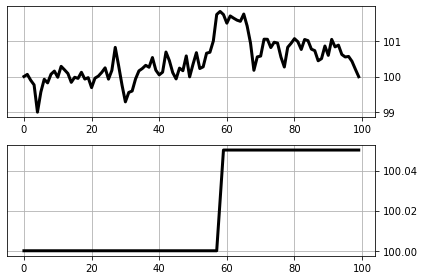

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1)

exog_prices = observations[:, ASSET_PRICE_INDEX, :]

time_space = np.linspace(0, terminal_time, len(exog_prices[0]))

ax1.plot(exog_prices[0][:100], lw=3, color='k')
ax2.plot([s[0][0] for s in arb_agent.historical_pool_prices][:100], lw=3, color='k')

for ax in (ax1, ax2): 
    ax.grid('both')
    ax.yaxis.tick_right()
plt.tight_layout()
plt.show()

In [17]:
observations, actions, rewards

(array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.00000000e-03, 2.00000000e-03, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+02, 1.00059784e+02, 9.98944764e+01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]),
 array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,